In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.set_option('display.float_format', lambda x: '%.3f' % x)
%matplotlib inline

## Allstate Claims Severity
[Kaggle](https://www.kaggle.com/c/allstate-claims-severity)  
When you’ve been devastated by a serious car accident, your focus is on the things that matter the most: family, friends, and other loved ones. Pushing paper with your insurance agent is the last place you want your time or mental energy spent. This is why Allstate, a personal insurer in the United States, is continually seeking fresh ideas to improve their claims service for the over 16 million households they protect. Allstate is currently developing automated methods of predicting the cost, and hence severity, of claims. 

In [4]:
!unzip train.csv.zip

Archive:  train.csv.zip
  inflating: train.csv               


In [5]:
data = pd.read_csv('train.csv')

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188318 entries, 0 to 188317
Columns: 132 entries, id to loss
dtypes: float64(15), int64(1), object(116)
memory usage: 189.7+ MB


You should predict the value for the `loss` column. Variables prefaced with `cat` are categorical, while those prefaced with `cont` are continuous.

In [7]:
data.isnull().any().any()

False

## Analyze target variable

In [8]:
data['loss'].describe()

count   188318.000
mean      3037.338
std       2904.086
min          0.670
25%       1204.460
50%       2115.570
75%       3864.045
max     121012.250
Name: loss, dtype: float64

- There're 188 318 rows (objects).
- Minumum is 0.67 and maxiumum 121 012.25.
- The avarage (mean) is 3037.338
- There's a big difference between 75th and 100th(max), should be long tail by right side.

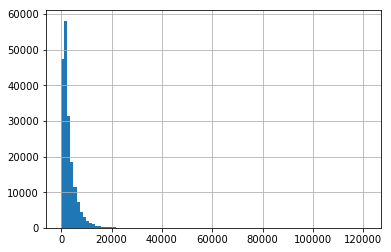

In [9]:
data['loss'].hist(bins=100)

As usually, for those tasks, distrubution is right skewed (long tail by right side) and there're some outliers.

There're few approaches how to manage outliers:
1. remove 1 or 2 % the biggest values (usually this is outliers)
2. transform data by function which is work fine with outliers (e.g. log transformation)

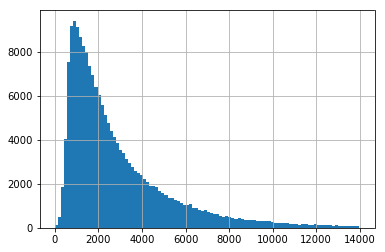

In [10]:
data[ data.loss < np.percentile(data.loss, 99) ]['loss'].hist(bins=100)

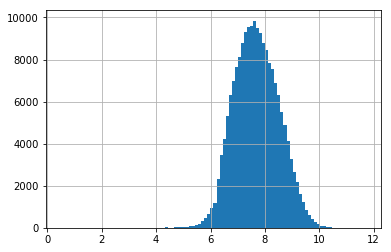

In [12]:
data['log_loss'] = np.log( data['loss'] + 1 )
data['log_loss'].hist(bins=100);

## Categorical variables
Has prefix `cat` in the name

In [13]:
cat_feats = [feat for feat in data.columns if 'cat' in feat]
print(len(cat_feats),  cat_feats)

116 ['cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'cat6', 'cat7', 'cat8', 'cat9', 'cat10', 'cat11', 'cat12', 'cat13', 'cat14', 'cat15', 'cat16', 'cat17', 'cat18', 'cat19', 'cat20', 'cat21', 'cat22', 'cat23', 'cat24', 'cat25', 'cat26', 'cat27', 'cat28', 'cat29', 'cat30', 'cat31', 'cat32', 'cat33', 'cat34', 'cat35', 'cat36', 'cat37', 'cat38', 'cat39', 'cat40', 'cat41', 'cat42', 'cat43', 'cat44', 'cat45', 'cat46', 'cat47', 'cat48', 'cat49', 'cat50', 'cat51', 'cat52', 'cat53', 'cat54', 'cat55', 'cat56', 'cat57', 'cat58', 'cat59', 'cat60', 'cat61', 'cat62', 'cat63', 'cat64', 'cat65', 'cat66', 'cat67', 'cat68', 'cat69', 'cat70', 'cat71', 'cat72', 'cat73', 'cat74', 'cat75', 'cat76', 'cat77', 'cat78', 'cat79', 'cat80', 'cat81', 'cat82', 'cat83', 'cat84', 'cat85', 'cat86', 'cat87', 'cat88', 'cat89', 'cat90', 'cat91', 'cat92', 'cat93', 'cat94', 'cat95', 'cat96', 'cat97', 'cat98', 'cat99', 'cat100', 'cat101', 'cat102', 'cat103', 'cat104', 'cat105', 'cat106', 'cat107', 'cat108', 'cat109', 'cat110', 'ca

There're 116 categorical variables.
Let's check cardinality (how many unique values each category has)

In [14]:
unq_values = [data[cat].nunique() for cat in cat_feats]

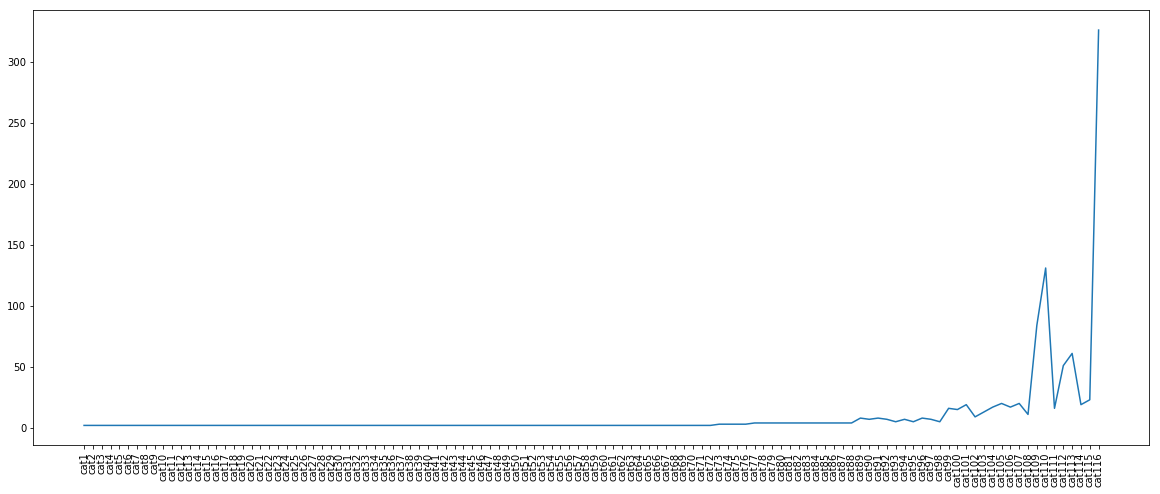

In [21]:
id_cat_feats = range(len(cat_feats))
plt.figure(figsize=(20, 8))
plt.plot(id_cat_feats, unq_values)
plt.xticks(id_cat_feats, cat_feats, rotation='vertical');

Let's remove last 20 elements, to verify how looks like smaller data.

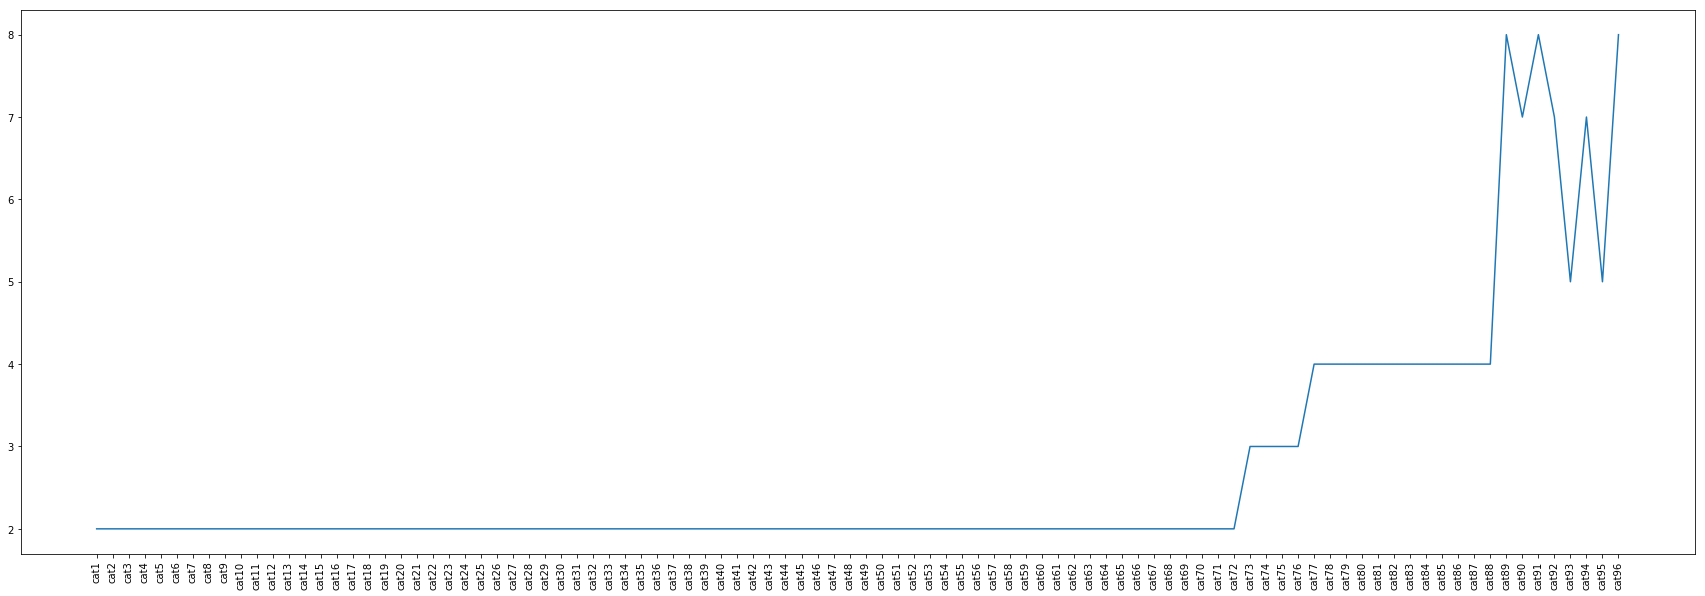

In [22]:
cut_last_elems = 20
plt.figure(figsize=(30, 10))
plt.plot(id_cat_feats[:-cut_last_elems], unq_values[:-cut_last_elems])
plt.xticks(id_cat_feats[:-cut_last_elems], cat_feats[:-cut_last_elems], rotation='vertical');


#### Questions

1. Are there hight cardinality (let say more than 50 unique values)?
2. How many unique values have average categorical variables?
3. How this information could help you?

## Continuous variables
Has prefix `cont` in the name

In [23]:
cont_feats = [feat for feat in data.columns if 'cont' in feat]
print(len(cont_feats),  cont_feats)

14 ['cont1', 'cont2', 'cont3', 'cont4', 'cont5', 'cont6', 'cont7', 'cont8', 'cont9', 'cont10', 'cont11', 'cont12', 'cont13', 'cont14']


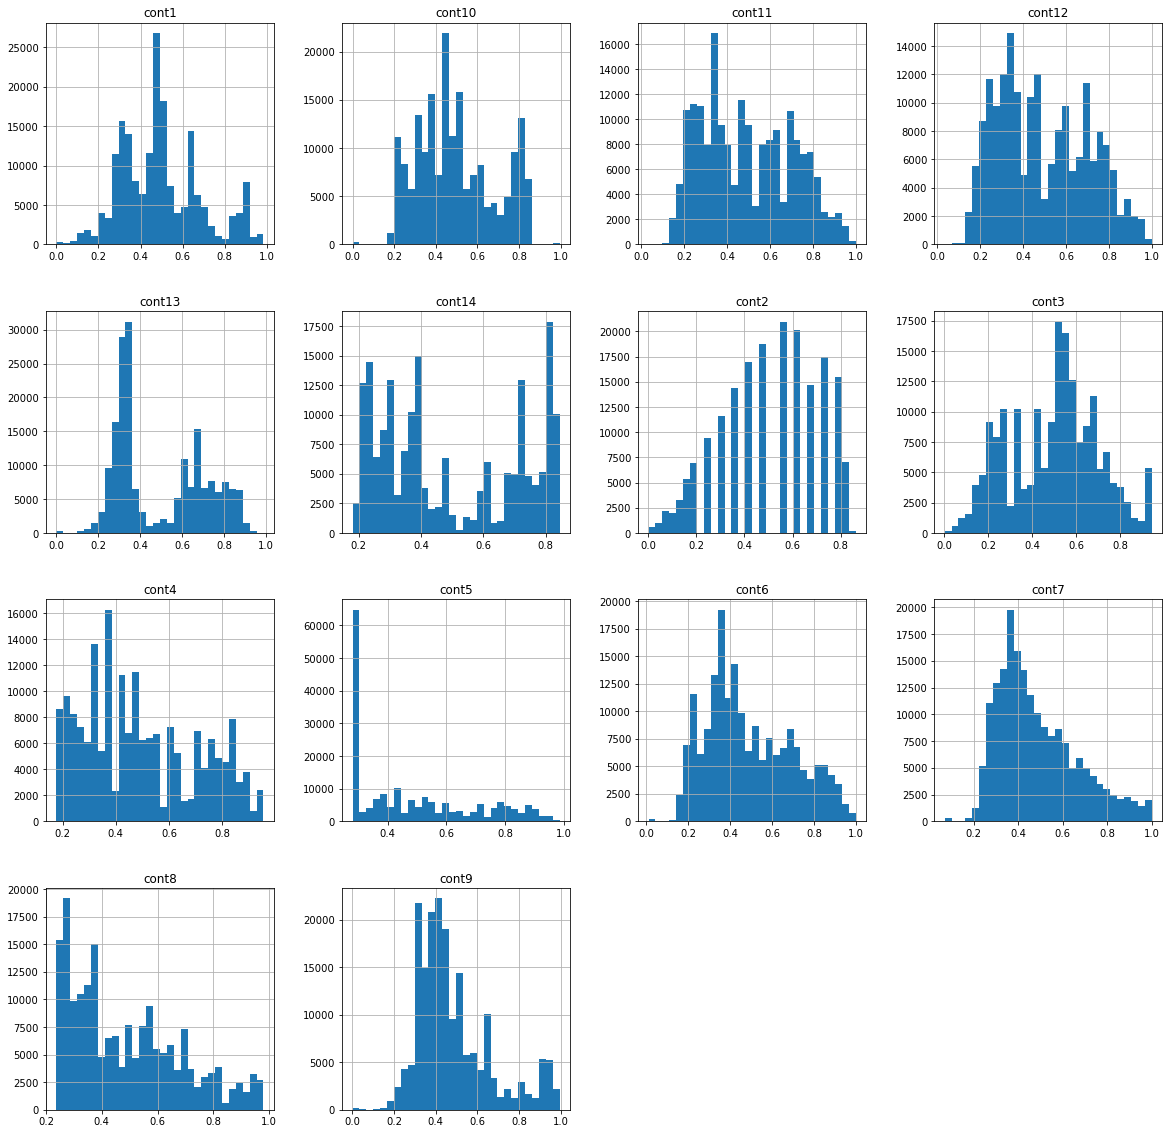

In [24]:
data[ cont_feats ].hist(bins=30, figsize=(20, 20));

What you can say about:
- distributions
- range (min and max)
- outliers

## Evaluation
### [Mean absolute error](https://en.wikipedia.org/wiki/Mean_absolute_error)

In practise the means, that you will calculate difference between your prediction and actual value for each points.
Letter sum up all of them and devide by count of points.

What the problem do you know about mae?

## Base Line
Let's build the simplest model

In [25]:
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_absolute_error

In [26]:
def base_line_model(data, target_variable='loss', strategy='mean'):
    X = data[cont_feats].values
    y = data[target_variable].values

    model = DummyRegressor(strategy=strategy)
    model.fit(X, y)
    y_pred = model.predict(X)

    if target_variable == 'log_loss':
        y = np.exp(y) - 1
        y_pred = np.exp(y_pred) - 1
        y_pred[ y_pred < 0 ] = 0

    score = mean_absolute_error(y, y_pred)
        
    return score

for strategy in ['mean', 'median']:
    for target_variable in ['loss', 'log_loss']:
        score = base_line_model(data, target_variable=target_variable, strategy=strategy)
        print(strategy, target_variable, score)

mean loss 1966.16528556
mean log_loss 1809.84698237
median loss 1809.04878647
median log_loss 1809.04878647


## Evaluation
To avoid overfitting is need more advaned way to validate result (e.g. cross validation)


### Task implement cross-validation
you can use DummyRegressor like a model

### TIP

In [27]:
from sklearn.cross_validation import KFold

nfolds = 3
folds = KFold(data.shape[0], n_folds=nfolds, shuffle = True, random_state = 2017)

for num_iter, (train_index, test_index) in enumerate(folds):
    pass
    #X_train, y_train = X[train_index], y[train_index]
    #X_test, y_test   = X[test_index], y[test_index]
    

/Users/vova/miniconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
